# Convolutional Neural Networks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

```text
𝗔𝘂𝘁𝗵𝗼𝗿: Ron Medina
𝗟𝗮𝘀𝘁 𝗠𝗼𝗱𝗶𝗳𝗶𝗲𝗱: 2022/06/27
𝗗𝗲𝘀𝗰𝗿𝗶𝗽𝘁𝗶𝗼𝗻: Convolutional neural networks: theory and implementation. Important aspects of CNN training: data augmentation and transfer learning.
𝗔𝘁𝘁𝗿𝗶𝗯𝘂𝘁𝗶𝗼𝗻: This notebook builds on Chapter 14 of (https://github.com/rasbt/machine-learning-book/) released under MIT License (https://github.com/rasbt/machine-learning-book/blob/main/LICENSE.txt) and the Keras guide on Transfer Learning and Fine-Tuning (https://keras.io/guides/transfer_learning).
```

---

## Introduction

In previous notebooks, we classified images by flattening them into long vectors as inputs to vanilla neural networks. This is unstatisfying since we are discarding important spatial information. For instance, we would get the same result if we permuted the pixels. Moreover, a layer that takes in a 256×256×3 RGB image and outputs an image of the same dimensionality requires around 39 billion parameters. This too much capacity for a single layer. And would take too much space in computer memory.

It would be nice if we can include our prior knowledge that pixels are spatially correlated in some way into the structure of our networks. For vision tasks, we can abstract away two desirable properties: **translation invariance** and **locality**. For our purposes, we take "translation invariance" to mean that a feature that is meaningful at a certain location should be equally meaningful at another place in the image. Moreover, discriminative features for images typically exist only on localized regions, e.g. a dog's nose or cat ears, so that looking at large regions of the image can potentially confuse the network. This also means that the resulting layer would require less weights since we are exploiting existing structure in the images. 

<br>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import random

import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras.datasets import cifar10


from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

import warnings
warnings.simplefilter(action="once")

from pathlib import Path
DATASET_DIR = Path("./data").absolute()

seed = 0
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

print(tf.config.list_physical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.8.0


## Convolution operation

Consider the following image of a cat. The two pixels on the left probably do not need to be mixed to figure out this is a cat. On the other hand, the three pixels on the right can form a linear combination that can be used to determine whether the image contains a cat. Suppose $\mathsf{S} = \mathsf{W} \mathsf{X}$ where $\mathsf{S}$ is the output image, $\mathsf{X}$ is the input image of size $\mathsf{n}^2$, and $\mathsf{W}$ are the weights. This means that pixels that are far away in the input correspond to weights that cannot be nonzero at the same time.

```{figure} ../../img/cat-conv.png
---
width: 40em
---
Nearby pixels constitute meaningful features of images.
```

This results in a weight matrix that is banded, i.e. reducing the size of the weight matrix from $\mathcal{O}(\mathsf{n}^4)$ to $\mathcal{O}(\mathsf{k}^2 \mathsf{n}^2)$ where a local region of $\mathsf k \times \mathsf{k}$ pixels can be mixed. The resulting matrix is a banded weight matrix $\mathsf{W}.$ Since we want to capture translationally invariant features, it makes sense to further constrain the weights in the local region to be equal througout the image. In this case, we get $\mathcal{O}(\mathsf{k}^2)$ weights.

```{margin}
[`deepimaging.github.io`](https://deepimaging.github.io/lectures/lecture_9_intro_to_CNN's.pdf)
```
```{figure} ../../img/conv-cat-99.png
---
width: 30em
---
Banded Toeplitz matrix for classifying cats. The violet bars contain the same pixel values. For images, since we concatenate rows into a long vector, we will actually have multiple bands in the weight matrix.
```

This linear operation is called a **convolution**. This can be written in two spatial dimensions as:

$$
\mathsf S_{ij} = (\mathsf X \circledast \mathsf W)_{ij} = \sum_{x = 0}^{{\mathsf k}_h-1} \sum_{y=0}^{{\mathsf k}_w-1} {\mathsf X}_{i + x, j + y} \, {\mathsf W}_{xy}.
$$

Observe that spatial ordering of the pixels in the input $\mathsf X$ is somehow preserved in the output $\mathsf S.$ This is nice since we want to preserve spatial information even when we stack many convolution operations.

### Convolutional layer

Replacing the dense operation with a convolution between the input and the weight tensors, we get the **convolutional layer** of a neural network. Note that we handle input and output channels as this allows for richer hidden representation, e.g. RGB images have three channels. The convolutional layer computes:

$$
\begin{aligned}
{\mathsf H}_{ij,\, k} 
&= \varphi\left({u}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1} ({\mathsf X}_{[:,\, :,\, c]} \circledast {\mathsf K}_{[:,\,:,\, c,\,{k}]})_{ij} \right) \\
&= \varphi\left({u}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1}\sum_{x = 0}^{{\mathsf k}_h-1} \sum_{y=0}^{{\mathsf k}_w-1} {\mathsf X}_{i + x,\, j + y,\, c} \, {\mathsf K}_{xyc,{k}} \right) \\
\end{aligned}
$$

for $k = 0, \ldots, {\mathsf c}_\text{out}-1$. The input and output tensors have the same dimensionality and semantic structure which makes sense since we want to stack convolutional layers in modular fashion. The shape of the weight tensor is $({\mathsf k}_h, {\mathsf k}_w, {\mathsf c}_\text{in}, {\mathsf c}_\text{out}).$

#### Kernel visualization

Observe that the computation in convolutional layers is analogous to computation dense layers: with units that process images instead of numbers. Here the number of output channels correspond to layer width or the number of features of the hidden representation. This can be visualized as follows.

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-13 22:10:39.297848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-13 22:10:39.297987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


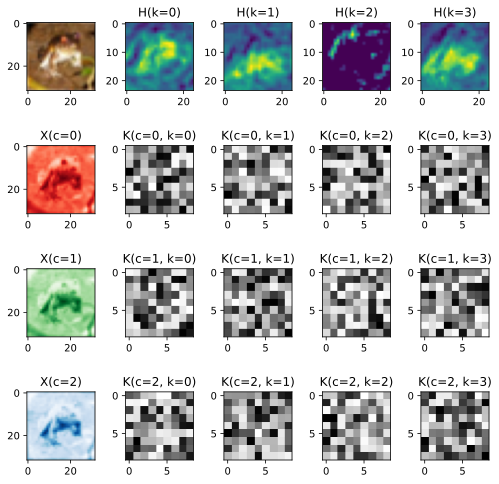

In [2]:
def visualize_conv_layer(*, X, conv):
    """Visualizing convolution kernels and output channels on a 3D image."""
    
    cmaps = ['Reds', 'Greens', 'Blues']
    H = conv(X[None, :, :, :])[0, :, :, :]
    c_in  = X.shape[-1]
    c_out = H.shape[-1]

    # Iterate over in channels
    fig, ax = plt.subplots(c_in+1, c_out+1, figsize=(7, 7))
    ax[0, 0].imshow(X[:, :, :])
    for c in range(c_in):
        ax[c+1, 0].set_title(f'X(c={c})')
        ax[c+1, 0].imshow(X[:, :, c], cmap=cmaps[c])

    # Iterate over out channels
    for k in range(c_out):
        ax[0, k+1].imshow(H[:, :, k])
        ax[0, k+1].set_title(f'H(k={k})')

    # Iterate over kernel filters
    for k in range(c_out):
        for c in range(c_in):
            K = conv.get_weights()[0][:, :, c, k]
            ax[c+1, k+1].imshow(K, cmap='Greys') 
            ax[c+1, k+1].set_title(f'K(c={c}, k={k})')

    fig.tight_layout()


(X_train, y_train), _ = cifar10.load_data()
conv = kr.layers.Conv2D(filters=4,  kernel_size=9, activation='relu')
X = X_train[0] / 255. # Frog?
visualize_conv_layer(X=X, conv=conv) 

Each kernel in entries `i, j > 0` combines column-wise with the inputs to compute `X(c=i) ⊛ K(c=i, k=j)`. The sum of these terms form the output map `H(k=j)` above. This has the structure of matrix multiplication which dense layers implement with numeric entries. But instead of products between numbers, here we have convolutions between matrices.

#### Implementation

Making sure that the formula discussed above is the same formula Keras uses in the `Conv2D` layer. Consistent with the above equation, this layer expects input images to have shape `(B, H, W, c)` for a batch input of size `B` of `H × W` images with `c` channels. This is also expected the shape of output of a convolutional layer.

Input shape:  (1, 32, 32, 3)
Output shape: (1, 24, 24, 4)
Kernel shape: (9, 9, 3, 4)
Bias shape:   (4,)
Mean absolute error = 1.0194157e-07


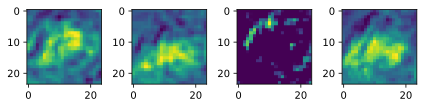

In [85]:
def conv2D(X, W, u, activation=None):
    """Implementing a 2D convolutional layer from scratch."""

    h, w = W.shape[:2]
    B, H0, W0, c_in = X.shape
    H1 = H0 - h + 1
    W1 = W0 - w + 1
    c_out = W.shape[3]

    S = np.zeros(shape=(B, H1, W1, c_out))

    for b in range(S.shape[0]):
        for i in range(S.shape[1]):
            for j in range(S.shape[2]):
                for k in range(S.shape[3]):
                    if activation is None:
                        f = lambda x: x
                    else:
                        f = activation

                    # Perform 3D convolution (h, w, c_in) for each out channel
                    S[b, i, j, k] = f(u[k] + (W[:, :, :, k] * X[b, i:i+h, j:j+w, :]).sum())
    return S


X = X_train[0][None, :, :, :] / 255.
W = conv.weights[0].numpy()
u = conv.weights[1].numpy()
S = conv2D(X, W, u, activation=lambda x: max(0, x))

print("Input shape: ", X.shape)   # (B, H_in,  W_in,  c_in)
print("Output shape:", S.shape)   # (B, H_out, W_out, c_out)
print("Kernel shape:", W.shape)   # (h, w, c_in, c_out)
print("Bias shape:  ", u.shape)   # (c_out,)

# Check if above formula agrees with TF implementation
print("Mean absolute error =", np.abs(S - conv(X)).mean())

# Plotting the images obtained using the above formula
fig, ax = plt.subplots(1, 4)
for j in range(4):
    ax[j].imshow(S[0, :, :, j])
fig.tight_layout()

Constructing the corresponding **Toeplitz matrix** of the operation:

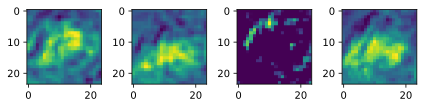

In [176]:
@np.vectorize
def np_relu(x):
    return max(x, 1e-16)

h, w = W.shape[:2]
B, H0, W0, c_in = X.shape
H1, W1 = H0 - h + 1, W0 - w + 1
c_out = W.shape[3]

# Constructing the Toeplitz matrix
T = np.zeros((X[0, :, :, 0].size, S[0, :, :, 0].size, c_in, c_out))
for c in range(c_out):
    for k in range(c_in):
        for i in range(H1):
            for j in range(W1):
                ii = i * W0 + j
                jj = i * W1 + j
                for hh in range(h):
                    T[ii + (hh * W0): ii + (hh * W0) + w, jj, k, c] = W[hh, :, k, c].reshape(-1)

# Computing the output image
fig, ax = plt.subplots(1, 4)
for c in range(c_out):
    s = np.zeros(H1 * W1)
    for k in range(c_in):
        x = X[0, :, :, k].reshape(-1)
        s += x @ T[:, :, k, c]
    ax[c].imshow(np_relu(s).reshape(H1, W1))

fig.tight_layout()    

Looks good! Toeplitz matrices for the first input channel:

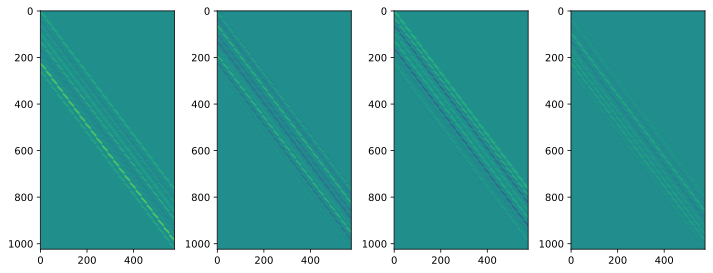

In [188]:
fig, ax = plt.subplots(1, c_out, figsize=(10, 6))
c = 0
for k in range(c_out):
    ax[k].imshow(T[:, :, c, k]);

plt.tight_layout()

Sparsity:

In [199]:
t = T[:, :, 0, 0]
(t != 0).sum() / t.size

0.0791015625

### Stride and padding

The above definition of convolution can be modified to include a parameter $s$ called the **stride** that controls the step size of the kernel when it slides over the input image. A convolution layer with stride $s$ computes:

$$
\begin{aligned}
{\mathsf H}_{ij,\, k} 
&= \varphi\left(u_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1}\sum_{x = 0}^{{\mathsf k}_h-1} \sum_{y=0}^{{\mathsf k}_w-1} {\mathsf X}_{si + x,\, sj + y,\, c} \, {\mathsf W}_{xyc,{k}} \right)
\end{aligned}
$$


for $k = 0, \ldots, {\mathsf c}_\text{out}-1.$ This includes the original definition which has a step size of 1. Note that strided convolutions can be thought of as a form of downsampling (discussed below) since it results in a significant reduction in image size. A larger stride along with a large kernel size can be useful if objects are large relative to the dimension of the image. For example, AlexNet {cite}`imagenet-paper` used a kernel of size 11×11 with a stride of 4 in the first layer since objects in the [ImageNet dataset](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description) tend to occupy more pixels. 

<br>

```{figure} ../../img/imagenet.jpeg
---
width: 45em
name: imagenet
---
Sample images from the ImageNet dataset. {cite}`imagenet`

```

**Padding.** Observe that in the above definition of convolution, the kernel placed entirely within the input image. This has the disadvantage of being biased towards the center pixels, resulting in information loss on the edges of the input image. 

Also notice that applying convolutions will always result in decreasing spatial dimension which limits the depth of the network. A simple fix is to simply pad the edges with zeros so the kernel can be placed over the edges:

(256, 34, 34, 1)


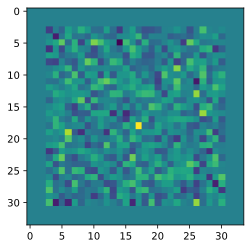

In [5]:
X = tf.random.normal(shape=(256, 28, 28, 1))            
pad = kr.layers.ZeroPadding2D(padding=3)

print(pad(X).shape)
plt.imshow(pad(X)[0, :, :, 0]);

### Output size

The spatial dimension of the output is directly influenced by padding `p` and stride `s`. Suppose the layer's input has width `W` and let the kernel have width `f`, then the output image has width `W_out = ⌊(W + 2p - f)/s⌋ + 1` assuming equal padding on both sides. 

Directly using discrete convolution is not always desirable as some pixels of the input are essentially dropped because a kernel cannot be placed within the image to cover them following the set stride:

```bash
input    1 2 3 4 5 6 7 8 9
kernel   0 0 1 0 0       
               0 0 1 0 0
         -----------------                     
output       3     6     
```

For odd kernel size `f` and unit stride `s = 1`, we can use `2p = f - 1` to get same sized outputs and with the kernel covering the entire input in a symmetric manner. For this reason, and also for the sake of symmetry, we prefer [odd-sized kernels](https://datascience.stackexchange.com/a/23186) for convolutions.

```bash
input    0 0 1 2 3 4 5 6 7 8 9 0 0
kernel   0 0 1 0 0
           0 0 1 0 0
                  ...
                       0 0 1 0 0
                         0 0 1 0 0
         -------------------------                        
output       1 2 3 4 5 6 7 8 9
```

For strides `s > 1`, the best practice is to choose a kernel size `f` and the smallest padding `p` such that `s` divides `W + 2p - f` so the entire input image is covered symmetrically by the kernel in constructing the convolved image.

```bash
input    0 1 2 3 4 5 6 7 8 9 0
kernel   0 0 1 0 0
               0 0 1 0 0
                     0 0 1 0 0
         ---------------------                         
output       2     5     8
```

<br>

**Remark.** The `padding` argument in convolutional layers in TensorFlow takes in either `"valid"` or `"same"`. The `"valid"` setting means that no padding is used an the kernel is placed only where it can be validly placed within the image. As discussed above this can result in discarding some pixels in the right as well as bottom part of the image. 

The `"same"` setting is a bit more tricky. Here the image is zero-padded as evenly as possible such that the output image has width `⌈W / s⌉`. So if `⌊(W + 2p - f) / s⌋ + 1 == ⌈W / s⌉`, such as when `s = 1` and `2p = f - 1`, then we can use `"same"` to implement a symmetric construction of the output as described above. Otherwise, we can apply `ZeroPadding2D` prior to convolution, resize the input images, or adjust the filter size as needed.

### Downsampling

For any unit of a hidden layer, its **receptive field** refers to all the units from all the previous layers that may affect the calculation of the unit during forward pass. In particular, units in the final classification layer should have a receptive field that contains the whole input image in the input layer. Otherwise, some parts of the input data will not improve the performance of the model for that class. 

```{margin}
**Figure 14.2** in {cite}`geron2019hands-on`
```
```{figure} ../../img/receptive_field.png
---
width: 35em
---
Receptive field of a pixel in the third layer.
```

One way to increase receptive field is by **downsampling** which is defined as taking a sample, or aggregating samples, of pixels in the current layer so that we can pass a smaller input onto the next layer. This results in lower computational costs and a reduction in the capacity of the network which can be good. Downsampling is commonly done by means of a **pooling** operation.

A pooling layer operates like a convolutional layer in that we can set a stride, padding, and kernel size. But unlike the convolution operation, pooling is non-parameteric. **Max-pooling** takes 
the maximum value in the region that is covered by its kernel. One effect of max pooling is that it provides invariance to small translations of the input at the cost of some information loss. Note that max-pooling works well with the ReLU activation since all activation values subject to comparison are all nonnegative.

[[5 9]
 [4 8]]


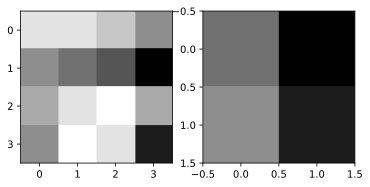

In [6]:
X = tf.convert_to_tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, :, :, None]

pool = kr.layers.MaxPool2D(pool_size=2, strides=2)


plt.subplot(1, 2, 1)
plt.imshow(X.numpy()[0, :, :, 0], cmap='gray_r', vmin=0)

plt.subplot(1, 2, 2)
plt.imshow(pool(X).numpy().reshape(2, 2), cmap='gray_r', vmin=0)
print(pool(X).numpy().reshape(2, 2))

Note that pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure. 
In practice, there are two commonly used settings: `k = 2` and `s = 2` where the pooling regions are do not overlap, and the more aggressive overlapping pooling with `k = 3` and `s = 2`. Using larger kernel sizes can be too aggressive resulting in worse performance. Observe below that there is more loss in finer detail when using overlapping pooling (right). 

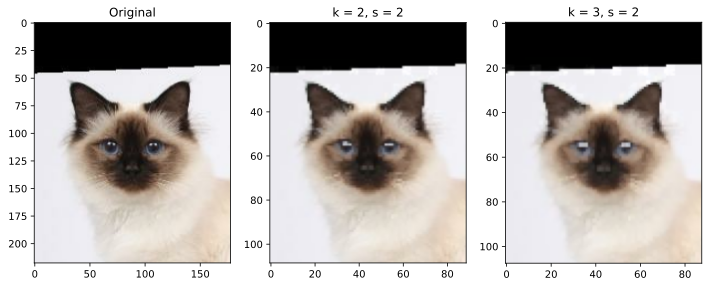

In [7]:
cat = DATASET_DIR / "cat.jpg"
image_raw = tf.io.read_file(str(cat))
image = tf.image.decode_image(image_raw)[None, :, :, :]

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image[0, :, :, :])
ax[0].set_title("Original")
ax[1].imshow(kr.layers.MaxPool2D(pool_size=2, strides=2)(image)[0, :, :, :])
ax[1].set_title("k = 2, s = 2")
ax[2].imshow(kr.layers.MaxPool2D(pool_size=3, strides=2)(image)[0, :, :, :])
ax[2].set_title("k = 3, s = 2");

## Implementing a convnet

Using the Keras sequential API, let us implement the following convolutional network for classifying [FashionMNIST](https://keras.io/api/datasets/fashion_mnist/) {cite}`fashion-mnist` images. Note that use a width of 512 in the last dense layer to reduce network capacity, instead of using 1024 indicated in the figure below. We also add [batch normalization](https://arxiv.org/abs/1502.03167) {cite}`batchnorm` and check whether this improves model performance. 

```{figure} ../../img/convnet.png
---
---
Visualizing the structure of `model` below. [[source]](https://github.com/rasbt/machine-learning-book/blob/main/ch14/figures/14_12.png)

```

Observe that the network follows the pattern where we stack `[Conv → ReLU → Pool]` blocks. This is typical in network design: using blocks composed of layers that together forms a basic functional unit. Here the spatial dimensions are downsampled while increasing the number of output channels, then the resulting long vector is passed to a dense classification subnetwork.

In [8]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same'),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPooling2D(pool_size=2, strides=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same'),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPooling2D(pool_size=2, strides=2),
    
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])

model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [9]:
def preprocess(data):
    data = data.reshape((-1, 28, 28, 1))
    data = data.astype('float32') / 255.
    return data 

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = preprocess(X_train)
X_test = preprocess(X_test)

# Split train and validation sets
X_valid = X_train[:10000]
y_valid = y_train[:10000]
X_train = X_train[10000:]
y_train = y_train[10000:]


# Compile model with Adam and cross-entropy
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train model on FashionMNIST data
hist = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=64,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20


2022-05-11 00:40:21.891983: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-11 00:40:22.153262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.8147

2022-05-11 00:40:35.232794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 15s 18ms/step - loss: 0.5333 - accuracy: 0.8147 - val_loss: 0.3316 - val_accuracy: 0.8760
Epoch 2/20
782/782 [==============================] - 14s 18ms/step - loss: 0.3492 - accuracy: 0.8727 - val_loss: 0.3008 - val_accuracy: 0.8896
Epoch 3/20
782/782 [==============================] - 14s 17ms/step - loss: 0.2996 - accuracy: 0.8913 - val_loss: 0.3114 - val_accuracy: 0.8878
Epoch 4/20
782/782 [==============================] - 13s 17ms/step - loss: 0.2673 - accuracy: 0.9025 - val_loss: 0.2472 - val_accuracy: 0.9073
Epoch 5/20
782/782 [==============================] - 13s 17ms/step - loss: 0.2454 - accuracy: 0.9104 - val_loss: 0.2239 - val_accuracy: 0.9156
Epoch 6/20
782/782 [==============================] - 14s 17ms/step - loss: 0.2241 - accuracy: 0.9175 - val_loss: 0.2262 - val_accuracy: 0.9148
Epoch 7/20
782/782 [==============================] - 13s 17ms/step - loss: 0.2061 - accuracy: 0.9235 - val_loss: 0.2273 - val_accuracy: 0.9184
Epo

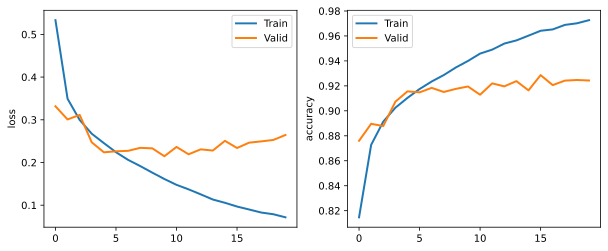

In [10]:
def plot_model_history(history, ax, metric='accuracy', label='', **kwargs):
    """Plotting result of Keras model training."""

    train_label = f'Train ({label})' if len(label) > 0 else 'Train'
    valid_label = f'Valid ({label})' if len(label) > 0 else 'Valid'
    ax[0].plot(history.history['loss'], label=train_label, color="C0", **kwargs)
    ax[0].plot(history.history['val_loss'], label=valid_label, color="C1", **kwargs)
    ax[0].set_ylabel('loss')
    ax[0].legend()

    ax[1].plot(history.history[metric], label=train_label, color="C0", **kwargs)
    ax[1].plot(history.history[f'val_{metric}'], label=valid_label, color="C1", **kwargs)
    ax[1].set_ylabel(metric)
    ax[1].legend()


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, linewidth=2)

In [11]:
print(f"Test accuracy: {model.evaluate(X_test, y_test)[1]}")

313/313 [==============================] - 2s 8ms/step - loss: 0.3148 - accuracy: 0.9184
Test accuracy: 0.9184000492095947


In [12]:
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

pred_proba = model.predict(X_test)
pred = np.argmax(pred_proba, axis=1)
pred_table = pd.DataFrame({
    'pred': pred, 
    'proba': [pred_proba[i, j] for (i, j) in enumerate(pred)], 
    'true': y_test.reshape(-1),
})

2022-05-11 00:45:01.581593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Plotting the examples where model is least confident in its prediction:

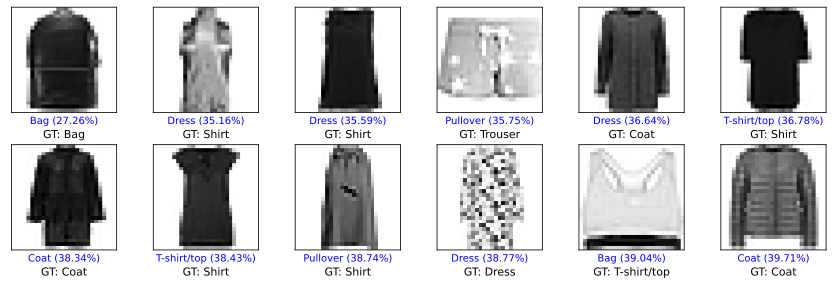

In [13]:
fig = plt.figure(figsize=(12, 4))
worst_preds = pred_table.sort_values('proba')[:12]

for i in range(12):
    img_index = worst_preds.index[i]
    image = X_test[img_index]
    row = worst_preds.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"{class_names[row['pred']]} ({row['proba']*100:.2f}%)", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

### Effect of batch normalization

Since we already have our experiment set up, might as well run some tests. Recall that we fitted batch normalization layers after the convolutional layers. Let us see how this affects model training.

In [14]:
model_no_bn = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    kr.layers.MaxPooling2D(pool_size=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
    kr.layers.MaxPooling2D(pool_size=2),
    
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])


# Build and compile with Adam and cross-entropy
model_no_bn.build(input_shape=(None, 28, 28, 1))
model_no_bn.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train on FashionMNIST data
hist_no_bn = model_no_bn.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=64,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
  5/782 [..............................] - ETA: 11s - loss: 2.0375 - accuracy: 0.2875 

2022-05-11 00:45:04.545255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.4585 - accuracy: 0.8351

2022-05-11 00:45:15.928418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 13s 16ms/step - loss: 0.4585 - accuracy: 0.8351 - val_loss: 0.3117 - val_accuracy: 0.8859
Epoch 2/20
782/782 [==============================] - 13s 16ms/step - loss: 0.2973 - accuracy: 0.8907 - val_loss: 0.2701 - val_accuracy: 0.9002
Epoch 3/20
782/782 [==============================] - 13s 16ms/step - loss: 0.2511 - accuracy: 0.9077 - val_loss: 0.2771 - val_accuracy: 0.8978
Epoch 4/20
782/782 [==============================] - 12s 16ms/step - loss: 0.2224 - accuracy: 0.9181 - val_loss: 0.2214 - val_accuracy: 0.9188
Epoch 5/20
782/782 [==============================] - 12s 16ms/step - loss: 0.1972 - accuracy: 0.9282 - val_loss: 0.2225 - val_accuracy: 0.9149
Epoch 6/20
782/782 [==============================] - 13s 16ms/step - loss: 0.1785 - accuracy: 0.9340 - val_loss: 0.2182 - val_accuracy: 0.9202
Epoch 7/20
782/782 [==============================] - 13s 16ms/step - loss: 0.1601 - accuracy: 0.9400 - val_loss: 0.2052 - val_accuracy: 0.9275
Epo

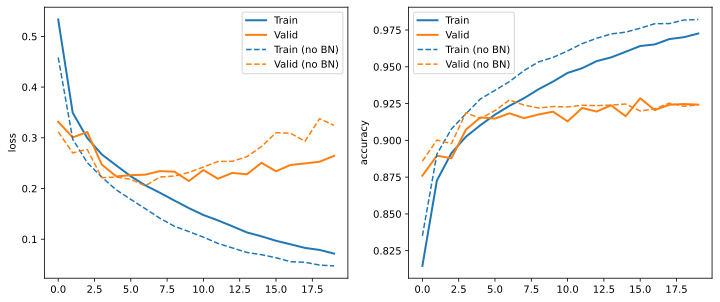

In [15]:
# Plot on same axis as prev model
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_model_history(history=hist, ax=ax, linewidth=2)
plot_model_history(history=hist_no_bn, ax=ax, label="no BN", linestyle="dashed")

Observe that the model with batch normalization exhibits less overfitting.

In [16]:
print(f"Test accuracy (BN):     {model.evaluate(X_test, y_test, verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy (w/o BN): {model_no_bn.evaluate(X_test, y_test, verbose=0)[1] * 100:.2f}%")

Test accuracy (BN):     91.84%
Test accuracy (w/o BN): 92.00%


## Data augmentation

In this section, we will create a convolutional network for classifying whether or not an image of a person is smiling or not. The dataset we will be using is [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) {cite}`celeb_a` which contains 202,599 images of celebrities’
faces. In addition, 40 binary facial attributes are available for each image, including whether a celebrity is smiling or not. 

To speed up training we will use only a small subset of 16,000 faces. However, this is a small dataset (even smaller than FashionMNIST). To increase the size of the dataset, and improve generalization, we will use **data augmentation**. This technique incorporates transformed versions of the original images into the dataset resulting in a model that is robust to changes that should not affect semantics such as rotation and translation.

```bash
USER="jessicali9530"
DATASET="celeba-dataset"
DATA_DIR=./data
mkdir ${DATA_DIR}
kaggle datasets download -d ${USER}/${DATASET} -p ${DATA_DIR}
unzip ${DATA_DIR}/${DATASET}.zip -d ${DATA_DIR}/${DATASET} > /dev/null
rm ${DATA_DIR}/${DATASET}.zip
```

```text
mkdir: ./data: File exists
Downloading celeba-dataset.zip to ./data
 100%|████████████████████████████████▉| 1.33G/1.33G [09:24<00:00, 3.13MB/s]
```

Plotting example images with their labels:

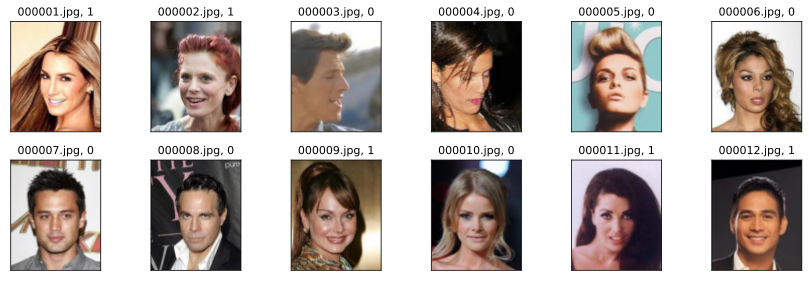

In [18]:
image_dir_path = DATASET_DIR / "celeba-dataset" / "img_align_celeba" / "img_align_celeba"
face_file_list = sorted([str(path) for path in image_dir_path.glob("*.jpg")])

# Get id -> target dictionary
dataset_path = DATASET_DIR / 'celeba-dataset'
attr = pd.read_csv(dataset_path / 'list_attr_celeba.csv')[['image_id', 'Smiling']]
attr['Smiling'] = attr['Smiling'].map({1: 1, -1: 0})
get_smile = dict(zip(attr.image_id, attr.Smiling))

# Plot examples from dataset
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_path = face_file_list[i]
    image_id = image_path.split('/')[-1]
    label = get_smile[image_id]
    image = plt.imread(image_path)

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.imshow(image)
    ax.set_title(f"{image_id}, {label}", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

### Transformations

For the sake of demonstration, we apply various transformations on a single image. These are cropping to a bounding box, flipping horizontally, adjusting the contrast, adjusting the brightness, and  center-cropping and resizing the resulting image back to its original size, 218×178. All of these are available in the [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) library.

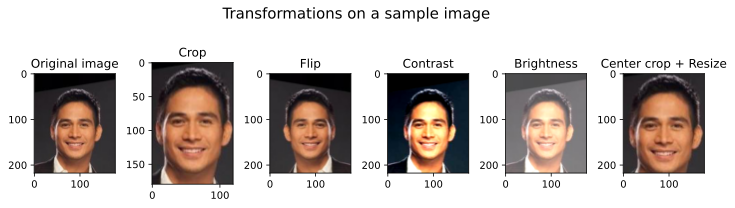

In [19]:
# Get sample image
image = plt.imread(face_file_list[11])

# Apply augmentations to sample image
cropped = tf.image.crop_to_bounding_box(image, 25, 30, 180, 120)
flipped = tf.image.flip_left_right(image)
contrast_adjusted = tf.image.adjust_contrast(image, 2.)
brightness_adjusted = tf.image.adjust_brightness(image, delta=0.3)
center_cropped = tf.image.central_crop(image, central_fraction=0.7)
resized_center_cropped = tf.image.resize(center_cropped, size=[218, 178]) / 255.

# Visualize
fig, ax = plt.subplots(1, 6, figsize=(10, 3))

ax[0].set_title("Original image")
ax[1].set_title("Crop")
ax[2].set_title("Flip")
ax[3].set_title("Contrast")
ax[4].set_title("Brightness")
ax[5].set_title("Center crop + Resize")

ax[0].imshow(image)
ax[1].imshow(cropped)
ax[2].imshow(flipped)
ax[3].imshow(contrast_adjusted)
ax[4].imshow(brightness_adjusted)
ax[5].imshow(resized_center_cropped)

fig.suptitle("Transformations on a sample image", fontsize=15)
fig.tight_layout()

Observe that the transformations above are all deterministic. The idea behind data augmentation is that we can inject randomness into these transformations to get new data points (assuming this transformation does not change the label). For example, the parameters for contrast and brightness change can be drawn from some uniform distribution. For our training dataset we apply a sequence of transformation: first we perform random cropping so the model can focus more on the face, this is followed by a random horizontal flip, and a final resize to 64×64. For test data, we remove the stochasticity as we want to avoid unnecessary information loss.

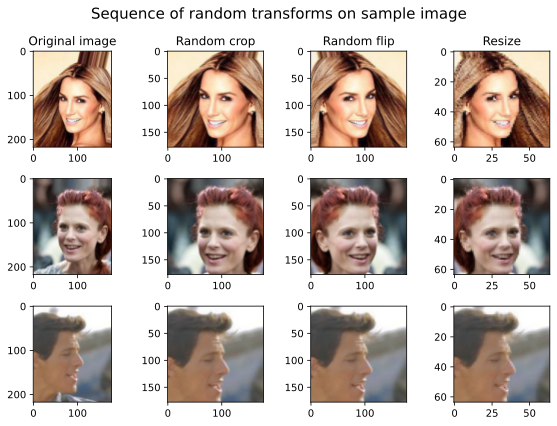

In [20]:
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

ax[0, 0].set_title("Original image")
ax[0, 1].set_title("Random crop")
ax[0, 2].set_title("Random flip")
ax[0, 3].set_title("Resize")

for i, file_name in enumerate(face_file_list[:3]):
    image = plt.imread(file_name)
    ax[i, 0].imshow(image)
    image = tf.image.random_crop(image, size=(178, 178, 3))
    ax[i, 1].imshow(image)
    image = tf.image.random_flip_left_right(image)
    ax[i, 2].imshow(image)
    image = tf.image.resize(image, size=[64, 64]) / 255.
    ax[i, 3].imshow(image)
    
fig.suptitle("Sequence of random transforms on sample image", fontsize=15)
fig.tight_layout()

The 64x64 images in the last column are those that will make up the training data. Next, we formalize this process by defining a tranformation pipeline and simulate how three sample images are presented to the model across multiple epochs. Note that we prefer using exactly one transformed version of an image per epoch so that the model is not biased, in contrast to the alternative of using multiple transformations of a single image in one epoch. We also want to avoid cropping too aggressively, otherwise we might crop the mouth out of the image which is highly predictive of a smile.

### Creating the augmented dataset

We now load the JPEG files into a TensorFlow dataset and apply the transformation to get a `MapDataset`. The whole process was introduced in a [previous notebook](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/01-tensorflow-nn.html#dataset-from-local-files). 

In [21]:
@tf.function
def transform(image, size=(64, 64), augment=True):
    """Full image transformation pipeline."""
    
    if augment:
        image = tf.image.random_crop(image, size=(178, 178, 3))
        image = tf.image.random_flip_left_right(image)
    else:
        image = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0, 
            target_height=178, target_width=178
        ) # (218 - 178)/2 = 20, (178 - 178)/2 = 0

    image = tf.image.resize(image, size=size) / 255.
    return image
    

def load_jpeg(file_path):
    image_raw = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    return image


def image_id(file_path):
    return file_path.split('/')[-1] 


def create_image_dataset(file_list):
    labels = [get_smile[image_id(file_path)] for file_path in file_list]
    paths_ds = tf.data.Dataset.from_tensor_slices((file_list, labels))
    image_ds = paths_ds.map(lambda file_path, label: (load_jpeg(file_path), label))
    return image_ds


# Create train, valid, and test data loaders outside of train loop.
# Here we assume that the dataset is shuffled in disk. Not sure though.
train_ds = create_image_dataset(face_file_list[:16000])
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(lambda x, y: (transform(x), y))

valid_ds = create_image_dataset(face_file_list[16000:17000])
valid_ds = valid_ds.map(lambda x, y: (transform(x, augment=False), y))

test_ds = create_image_dataset(face_file_list[17000:18000])
test_ds = test_ds.map(lambda x, y: (transform(x, augment=False), y))

Each dataset above is a `MapDataset` so that the mapping is applied lazily each time the dataset is iterated over. This is good since we want a different randomization for each epoch. Note that the ordering between `shuffle` and `map` seems to be significant as well as setting `reshuffle_each_iteration` to `True`. This is done so that `shuffle` [maintains state across iterations](https://github.com/tensorflow/tensorflow/issues/35682#issuecomment-578334425) and we get different augmentations for each epoch. Batch size for the data loaders will have to be set up later.

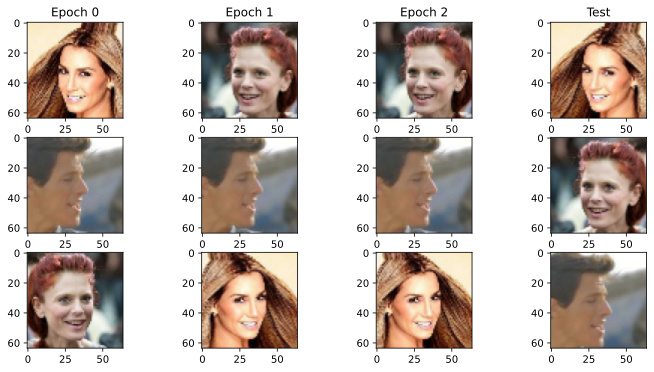

In [22]:
# In this demo, we likewise create loaders outside of train loops
train_demo = create_image_dataset(face_file_list[:3])
train_demo = train_demo.shuffle(1000)                           # order important! 
train_demo = train_demo.map(lambda x, y: (transform(x), y))     # shuffle -> map
train_demo = train_demo.batch(1)

fig, ax = plt.subplots(3, 4, figsize=(12, 6))

# Training
for epoch in range(3):
    ax[0, epoch].set_title(f"Epoch {epoch}")
    for b, batch in enumerate(train_demo):
        ax[b, epoch].imshow(batch[0][0, :, :, :])

# Inference: use same images for comparison
test_demo = create_image_dataset(face_file_list[:3])
test_demo = test_demo.map(lambda x, y: (transform(x, augment=False), y))
test_demo = test_demo.batch(1)

ax[0, 3].set_title(f"Test")
for b, batch in enumerate(test_demo):
    ax[b, 3].imshow(batch[0][0, :, :, :])

Checking if the labels are balanced so we can use accuracy as metric.

In [23]:
for ds in [train_ds, valid_ds, test_ds]:
    X, y = list(ds.batch(16000).as_numpy_iterator())[0]
    print(y.mean())

0.4813125
0.465
0.457


### Global average pooling

Now that we have our data loaders, let us look at the model architecture that we will use for smile classification. The input data goes through four convolutional layers to make 32, 64, 128, and 256 feature maps using 3×3 same convolutions, 2×2 nonoverlapping max-pooling blocks. Batch normalization layers are also included for regularization.

In [24]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=128, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=256, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.GlobalAveragePooling2D(),
    
    kr.layers.Flatten(),
    kr.layers.Dense(units=2, activation='softmax')
])

model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 64)      

At the final convolutional layer, we have 256 many 8×8 feature maps. Flattening this into a 256×8×8 = 16,384 long vector results in the loss of learned semantic structure. Not to mention the excess in capacity of the dense layer that takes this vector as input.

An alternative that we use here is a **global average-pooling** (GAP) layer which averages all pixels in the 8×8 feature map into a single pixel. Averaging over the spatial dimensions can make the model more robust to small spatial translations in the input. But more importantly, compressing the spatial dimension allows us to preserve the channel structure, while reducing the output to a vector of length 256. This vector can then be passed to a dense layer to perform classification. 

If the activations are nonnegative, each channel is forced to learn activation patterns, i.e. patterns in the kernel that result in activation, and averaging just summarizes how much the input matches this pattern. In fact, this has been used to construct maps which indicate the parts of the image that are discriminative!

<br>

```{figure} ../../img/cams.png
---
width: 50em
---
Global average pooling flattens the output of the convolutional base network. The outputs of the GAP layer are passed to a dense network with output dimension equal to the number of classes. It's learned weight is interpreted as importance and is used to construct maps which highlight class-specific discriminative regions. {cite}`cams`
```

### Model training and results

Training the model with Adam with a learning rate of $10^{-3}$ and a batch size of 32.

In [25]:
model.compile(
    loss=kr.losses.SparseCategoricalCrossentropy(),
    optimizer=kr.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Fit model with data augmentation
hist = model.fit(
    train_ds.batch(32),
    epochs=30,
    validation_data=valid_ds.batch(256)
)

Epoch 1/30


2022-05-11 00:49:28.495254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


499/500 [============================>.] - ETA: 0s - loss: 0.6101 - accuracy: 0.6649

2022-05-11 00:49:44.401530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 17s 33ms/step - loss: 0.6097 - accuracy: 0.6652 - val_loss: 0.7737 - val_accuracy: 0.5380
Epoch 2/30
500/500 [==============================] - 19s 37ms/step - loss: 0.4768 - accuracy: 0.7765 - val_loss: 0.5752 - val_accuracy: 0.7400
Epoch 3/30
500/500 [==============================] - 19s 38ms/step - loss: 0.3859 - accuracy: 0.8295 - val_loss: 0.4073 - val_accuracy: 0.8190
Epoch 4/30
500/500 [==============================] - 19s 38ms/step - loss: 0.3434 - accuracy: 0.8508 - val_loss: 0.3869 - val_accuracy: 0.8290
Epoch 5/30
500/500 [==============================] - 19s 38ms/step - loss: 0.3204 - accuracy: 0.8599 - val_loss: 0.5897 - val_accuracy: 0.7640
Epoch 6/30
500/500 [==============================] - 19s 38ms/step - loss: 0.2996 - accuracy: 0.8671 - val_loss: 1.0155 - val_accuracy: 0.6100
Epoch 7/30
500/500 [==============================] - 19s 38ms/step - loss: 0.2884 - accuracy: 0.8751 - val_loss: 0.3268 - val_accuracy: 0.8600
Epo

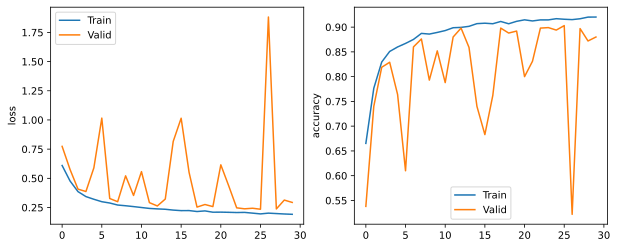

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax)

This looks good &mdash; the minimum validation loss roughly moves along with the train loss as the training progresses. One way to smooth out the validation curve is to get higher resolution input images. But here we already see that the network is able to learn with only 16,000 images by using data augmentation. In fact, if we turn off data augmentation, we get extreme divergence where the model overfits early on in the training. Again, this makes sense: adding random transformations on the train set makes it harder for the model to memorize it. At the same time, it learns to pick up representations that are invariant to these random perturbations in the inputs.



In [27]:
print(f"Train accuracy: {model.evaluate(train_ds.batch(1000), verbose=0)[1] * 100:.2f}%") # stochastic
print(f"Valid accuracy: {model.evaluate(valid_ds.batch(1000), verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy:  {model.evaluate(test_ds.batch(1000),  verbose=0)[1] * 100:.2f}%")

Train accuracy: 90.96%
Valid accuracy: 88.00%
Test accuracy:  88.90%


In [28]:
pred_proba = model.predict(test_ds.batch(1000))[:, 1]
X_test, y_test = next(iter(test_ds.batch(1000)))
pred_table = pd.DataFrame({'pred': pred_proba, 'true': y_test})

2022-05-11 00:59:36.198123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


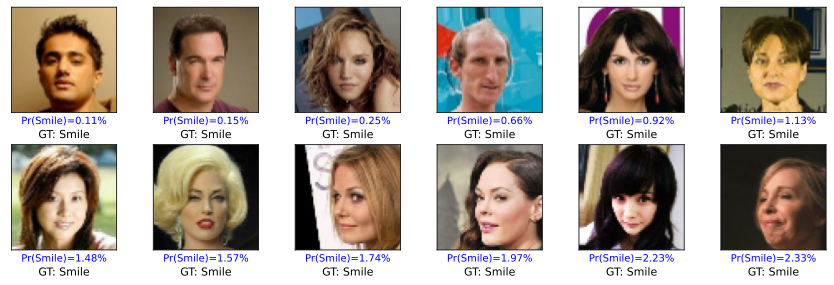

In [29]:
class_names = {
    0: 'Not Smile',
    1: 'Smile'
}

# Create distance of prediction from threshold of 0.5
pred_table['thresh_dist'] = np.abs(pred_table['pred'] - 0.5)
pred_table['correct'] = (pred_table['pred'] > 0.5) == pred_table['true']

confused = (pred_table
    .sort_values('thresh_dist', ascending=False)
    .query('correct == False')
)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    img_index = confused.index[i]
    image = X_test[img_index]
    row = confused.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where the model is confident (gives a predict probability near either 0 or 1) but also wrong. This gives us an opportunity to check whether some labels are flipped. 

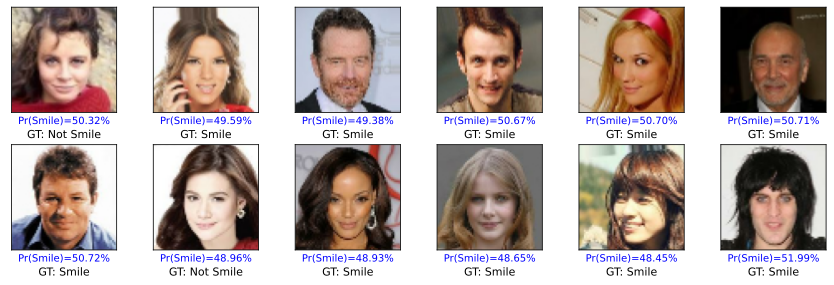

In [30]:
near_threshold = pred_table.sort_values('thresh_dist', ascending=True)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_index = near_threshold.index[i]
    image = X_test[image_index]
    row = near_threshold.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where model is not sure of whether the face is smiling or not (it gives a predict probability that is far from either 0 or 1). Probably the fact that teeth are either occluded or absent gives the model a hard time in detecting a smile.

## Class activation maps

Previously, we introduced the concept of **class activation maps** (CAMs) in the context of GAP layers. We will try to construct this for the current model. This constuct a map which highlights the class-specific discriminative regions of an input image. The construction is based on the paper {cite}`cams`. So a GAP-CNN network does not only tell us what objects are present in the image, it also tells us where these objects are in the image and with no further training!

Looking at the model summary, note that the GAP layer output has 258 units. To construct the class activation maps, for each input $\mathbf x$ we take the activations of the final ReLU layer which has shape (8, 8, 256) as **activation maps** $f_i(\mathbf x)$ of shape (8, 8) for $i = 1, \ldots, 256$ with nonnegative pixel values. Then, we take the weights $w_{ij}$ of the dense layer which maps the output of the GAP layer to binary classes with label $j$ (smile or not smile), and compute the sum

$$\textsf{CAM}(\mathbf x, j) = \sum_{i=1}^{256}  f_i(\mathbf x) w_{ij}.$$

The resulting image is (8, 8) which we can resize for better resolution. Then we overlay this on the input image $\mathbf x$ resized to the same height and width. Thus, what we've done here is expand the linear combination of zero-dimensional average activation values to a linear combination of 2-dimensional activation maps. CAMs are implemented in the following code block for test examples.

Note that class scores are obtained by a linear combination of the average pixel values in each activation map. Since spatial ordering is preserved by convolutional layers, then the activations should indicate which pixels in the input that is in its receptive field triggered the activation, i.e. whose local representation matched the pattern in the kernel. Moreover, since the activation maps have positive pixel values, we can use the weights in the linear combination as a measure of importance for each activation for a given class.

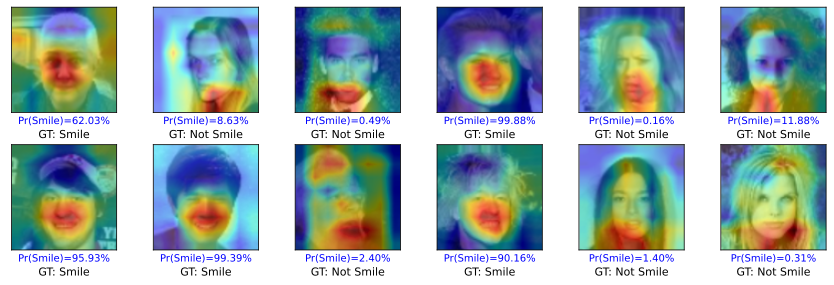

In [31]:
from functools import reduce

def plot_cam(batch, height=96, width=96):
    """Plot class activation maps (CAM) for each image in batch.
    The CAM will be taken with respect to the predicted label."""

    X, Y = batch
    class_label = {0: 'Not Smile', 1: 'Smile'}
    class_weight = model.layers[-1].get_weights()[0]
    resize = kr.layers.Resizing(height, width)
    fig, ax = plt.subplots(2, 6, figsize=(12, 4))

    for b in range(12):
        x = X[b, :, :, :][None, :, :, :]
        y = Y[b]
        t = tf.argmax(model(x), axis=1)[0]

        # Apply layers up to final conv. activation. (1, 8, 8, 256) -> (64, 256)
        act_map = tf.reshape(reduce(lambda x, f: f(x), model.layers[:-4], x), (-1, 256))
        weights = class_weight[:, t][:, None]
        cam = act_map @ weights
        cam = resize(tf.reshape(cam, (8, 8, 1)))
        
        ax[divmod(b, 6)].imshow(resize(x[0]))
        ax[divmod(b, 6)].imshow(cam, alpha=0.7, cmap='jet')
        ax[divmod(b, 6)].set_xlabel(f"Pr(Smile)={model(x)[0, 1]*100:.2f}%", color='blue')
        ax[divmod(b, 6)].set_title(f"GT: {class_label[y.numpy()]}", y=-0.3, fontsize=11)
        ax[divmod(b, 6)].set_xticks([])
        ax[divmod(b, 6)].set_yticks([])

    fig.tight_layout()


plot_cam(batch=next(iter(test_ds.batch(12)))) # Detect smile

**Figure.** CAMs of test images for the predicted class. Red regions indicate high activation values, hence local discriminative features. Notice that the model is able to find discriminative features around the mouth area for detecting the presence of smile. This becomes more defined as the confidence of the model increases. For not smile, although the activation regions are not as well-defined, the model still focuses around the mouth area.

## Transfer learning

**Transfer learning** consists of taking weights, and hence feature representations, learned on one problem, and leveraging them on a new, similar problem. In the following experiment, we will use a [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) {cite}`mobilenet` model pretrained on ImageNet. This has around 2.3 million parameters and was designed to have fast inference times for resource constrained environments.


```{margin}
**Figure 8.12** in {cite}`keras2`
``` 
```{figure} ../../img/transfer-learning.png
---
width: 40em
---
Replacing with a new classifiers while keeping the same convolutional base.
```

Observe that the convolutional networks we encountered consist of two subnetworks: a convolutional base, that acts as a feature extractor, and a classifier on top of the base network, that processes the extracted features to get class probabilities. The idea behind transfer learning is that we can take the convolutional base, that is extensively trained on a large dataset, and use its learned representations to train a new classifier on a similar task. This leads us to the following workflow:

 1. Instantiate a base model and load pre-trained weights into it.
 2. Freeze all layers in the base model by setting `trainable = False`.
 3. Add new layers on top of the base model.
 4. Train your new model on your new dataset.

An alternative workflow is to pass the input data *once* to the base model to get feature vectors. These vectors are then used to train a new, smaller model. This is cheaper, but we obviously cannot use it along with data augmentation which transforms input data at each training iteration.

In [32]:
base_model = kr.applications.MobileNetV2(
    weights='imagenet',         # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),    # We will have to resize for our 64x64x3 train dataset.
    include_top=False           # Do not include the ImageNet classifier at the top.
)

# Freeze the weights
base_model.trainable = False

# Stack a classification subnetwork on top
inputs = kr.Input(shape=(64, 64, 3))
x = kr.layers.Resizing(96, 96)(inputs)
x = base_model(x, training=False)          # Inference mode! ⚠⚠⚠
x = kr.layers.AvgPool2D(pool_size=3)(x)    # 3x3x1280 -> 1x1x1280. Remove for performance. 
x = kr.layers.Flatten()(x)
x = kr.layers.Dense(256, activation='relu')(x)
x = kr.layers.Dropout(0.5)(x)
outputs = kr.layers.Dense(1)(x)

model = kr.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               327936

Setting `model.trainable` to `False` recursively moves all trainable weights to non-trainable. In particular, this has the side-effect of disabling updates to batch normalization statistics. This makes sense since the trainable parameters that they interact with are frozen. Note that this side-effect is redundant with `base_model(x, training=False)`.

**Remark.** This last setting will be important when we unfreeze the pretrained model weights for fine-tuning. According to the [Keras FAQ](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute), it is usually still better to keep the moving statistics frozen when fine-tuning even while the trainable parameters are updating. Forcing pretrained model calls in inference mode does exactly this, as it is not overridden by training calls to `model` (see appendix).

In [33]:
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Fit model with data augmentation
hist = model.fit(
    train_ds.batch(32),
    epochs=20,
    validation_data=valid_ds.batch(256)
)

Epoch 1/20


2022-05-11 00:59:42.058365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


499/500 [============================>.] - ETA: 0s - loss: 0.5902 - binary_accuracy: 0.6824

2022-05-11 01:00:06.018983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 29s 54ms/step - loss: 0.5905 - binary_accuracy: 0.6822 - val_loss: 0.5490 - val_binary_accuracy: 0.7350
Epoch 2/20
500/500 [==============================] - 31s 61ms/step - loss: 0.5291 - binary_accuracy: 0.7231 - val_loss: 0.5458 - val_binary_accuracy: 0.6940
Epoch 3/20
500/500 [==============================] - 31s 61ms/step - loss: 0.5165 - binary_accuracy: 0.7331 - val_loss: 0.5165 - val_binary_accuracy: 0.7360
Epoch 4/20
500/500 [==============================] - 30s 59ms/step - loss: 0.5071 - binary_accuracy: 0.7390 - val_loss: 0.5178 - val_binary_accuracy: 0.7380
Epoch 5/20
500/500 [==============================] - 31s 60ms/step - loss: 0.4993 - binary_accuracy: 0.7453 - val_loss: 0.5028 - val_binary_accuracy: 0.7410
Epoch 6/20
500/500 [==============================] - 32s 63ms/step - loss: 0.4909 - binary_accuracy: 0.7496 - val_loss: 0.5090 - val_binary_accuracy: 0.7430
Epoch 7/20
500/500 [==============================] - 30s 60ms/

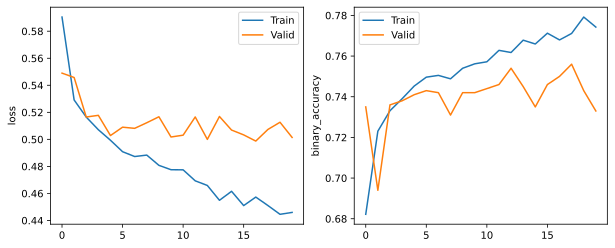

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, metric='binary_accuracy')

In [35]:
print(f"Train accuracy: {model.evaluate(train_ds.batch(1000), verbose=0)[1] * 100:.2f}%")
print(f"Valid accuracy: {model.evaluate(valid_ds.batch(1000), verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy:  {model.evaluate(test_ds.batch(1000),  verbose=0)[1] * 100:.2f}%")

Train accuracy: 76.91%
Valid accuracy: 73.30%
Test accuracy:  74.20%


### Fine-tuning

A last, optional step, is **fine-tuning**, which consists of unfreezing the pre-trained model, or part of it, on the new task with very low learning rate. This can potentially achieve meaningful improvements. But could also potentially lead to quick overfitting due to the potentially large number of parameters in the base model which is why we use a small learning rate. 

Note that it is critical to fine-tune a model only after the model with frozen layers has been trained to convergence. Mixing pretrained layers with randomly initialized layers will destroy the pretrained weights due to large gradient updates during the early stages of training.

In [36]:
# Unfreeze the base model.
base_model.trainable = True

# Recompile to take unfreezing into account.
model.compile(
    optimizer=kr.optimizers.Adam(1e-5),  # Very low learning rate
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Train end-to-end. Be careful to stop before you overfit!
callback = kr.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

# Batch normalization still runs in inference mode. (See appendix.)
epochs = 10
hist = model.fit(
    train_ds.batch(32), 
    epochs=epochs, 
    validation_data=valid_ds.batch(256),
    callbacks=[callback]
)

Epoch 1/10


2022-05-11 01:10:58.178983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 0.4025 - binary_accuracy: 0.8043

2022-05-11 01:12:02.662297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 77s 139ms/step - loss: 0.4025 - binary_accuracy: 0.8043 - val_loss: 0.4203 - val_binary_accuracy: 0.8030
Epoch 2/10
500/500 [==============================] - 66s 131ms/step - loss: 0.3356 - binary_accuracy: 0.8391 - val_loss: 0.3758 - val_binary_accuracy: 0.7960
Epoch 3/10
500/500 [==============================] - 82s 161ms/step - loss: 0.2998 - binary_accuracy: 0.8614 - val_loss: 0.3294 - val_binary_accuracy: 0.8580
Epoch 4/10
500/500 [==============================] - 86s 167ms/step - loss: 0.2653 - binary_accuracy: 0.8793 - val_loss: 0.3113 - val_binary_accuracy: 0.8580
Epoch 5/10
500/500 [==============================] - 73s 143ms/step - loss: 0.2508 - binary_accuracy: 0.8854 - val_loss: 0.3151 - val_binary_accuracy: 0.8590
Epoch 6/10
500/500 [==============================] - 70s 138ms/step - loss: 0.2348 - binary_accuracy: 0.8911 - val_loss: 0.2852 - val_binary_accuracy: 0.8790
Epoch 7/10
500/500 [==============================] - 68s

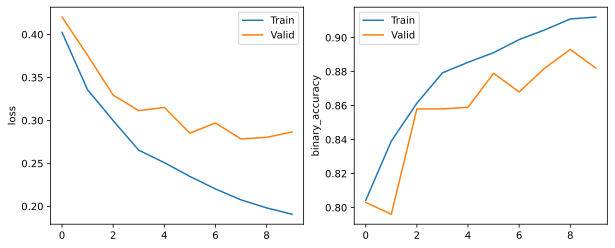

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, metric='binary_accuracy')

As expected, the model is starting to overfit due to overcapacity (the train-valid loss gap is widening). And we were not able to obtain a better test scores with fine-tuning (see below). It would be nice if we had better results with transfer learning (before fine-tuning), but this is likely due to hardware limitations. For more powerful systems, we expect better performing networks with transfer learning.

In [38]:
print(f"Train accuracy: {model.evaluate(train_ds.batch(1000), verbose=0)[1] * 100:.2f}%")
print(f"Valid accuracy: {model.evaluate(valid_ds.batch(1000), verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy:  {model.evaluate(test_ds.batch(1000),  verbose=0)[1] * 100:.2f}%")

Train accuracy: 91.79%
Valid accuracy: 88.20%
Test accuracy:  88.50%


## Appendix

### MobileNetV2 architecture

In [39]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

### Batch normalization layers in transfer learning

Testing two facts about batch norm layers: 1) that batch norm layers are forced to run in inference mode when weights are frozen &mdash; these are, in principle, unrelated concepts &mdash; and 2) setting `base_model` calls to inference mode keeps its batch normalization layers in inference mode even if outer `model` calls are in training mode.

In [7]:
def training_mean_change(model, bn_layer):
    """Max change in mean of BN layer after one call in training mode."""

    # Get sample input
    x = tf.random.normal((1, 3))

    # Change in mean after one call in train mode
    u0 = bn_layer.weights[2].numpy()
    model(x, training=True)
    u1 = bn_layer.weights[2].numpy()
    
    return (u1 - u0).max()


# Control: training mode, trainable weights
x = kr.Input(shape=(3,))
h = kr.layers.BatchNormalization()(x)
model = kr.Model(inputs=x, outputs=h)

print(model.layers[1].name)
training_mean_change(model, bn_layer=model.layers[1])

batch_normalization


0.00051729346

Running the same experiment with frozen weights in training mode. Getting `0.0` proves the first fact above.

In [8]:
# Freeze weights => BN inference mode
model.trainable = False
training_mean_change(model, bn_layer=model.layers[1])

0.0

Next, we mimic the network structure for a transfer learning fine-tuning task. Recall that `base_model` is set in inference mode inside `model`. Getting `0.0` with trainable weights and running the outer model in training mode proves the second fact above about BN implementation.

In [9]:
# "Pretrained model"
x = kr.Input(shape=(3,))
h = kr.layers.BatchNormalization()(x)
y = kr.layers.Dense(1024)(h)
base_model = kr.Model(inputs=x, outputs=y)

# Pretrained model in inference mode
x = kr.Input(shape=(3,))
y = base_model(x, training=False)
y = kr.layers.Dense(10)(y)
model = kr.Model(inputs=x, outputs=y)

# Model training...
print(model.layers[1].layers[1].name)
training_mean_change(model, bn_layer=model.layers[1].layers[1])

batch_normalization_1


0.0